In [ ]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
import matplotlib as mpl
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import numpy as np
from scipy.special import erfcinv
from scipy.stats import chi2, gamma
from scipy.special import erfcinv
from scipy.linalg import sqrtm

import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

import git
import os

from math import erf, sqrt

# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_global = os.path.dirname(path_git)
print('Path to git repo: {}'.format(path_global))

chi2_val = chi2.ppf(0.6827, df=2)

d = 2
L = 3  # Number of vectors
n_samples = int(1e6)

Path to git repo: /home/matias/Documents/PhD/code


# PTE to $N_{\sigma}$

Que es $N_{\sigma}^{eff}$? Hagamos algunos graficos

In [2]:
def L_iso_from_n(d: int, n: float, sigma2: float = 0.5, gauss_scale: str = '1sigma') -> float:
    """
    Distancia euclídea L entre las medias de dos Gaussianas D-dimensionales
    idénticas e isotrópicas (Sigma = sigma2 * I), tal que sus contornos 
    que en 1D corresponden a ±nσ se 'toquen'.

    Parámetros
    ----------
    d : int
        Dimensión (D).
    n : float
        'Número de sigmas' 1D (es decir, p = erf(n / sqrt(2))).
    sigma2 : float, opcional
        Varianza isotrópica por eje (default 0.5).

    Devuelve
    --------
    L : float
        Distancia euclídea entre medias.
    """


    if gauss_scale == '1sigma':
        # Probabilidad 1D asociada a ±nσ
        p = erf(n / sqrt(2.0)) #is the same, less general
        #p = chi2.cdf(n**2, df=1)  # Cumulative distribution function for chi2Q
    elif gauss_scale == '2sigma':
        p = chi2.cdf(n**2, df=2)  # Cumulative distribution function for chi2

    # Cuantil chi-cuadrado con d grados de libertad
    m2 = chi2.ppf(p, df=d)              # m^2 = χ²_{d,p}
    m  = sqrt(m2)
    # En isotrópico: L = 2 * σ * m, con σ = sqrt(sigma2)
    return 2.0 * sqrt(sigma2) * m

print('--- Using 1sigma scale ---')
for n in [1, 2, 3, 4, 5]:
    print(n, L_iso_from_n(d=2, n=n))   # d=2, sigma^2=0.5

print('--- Using 2sigma scale ---')
for n in [1, 2, 3, 4, 5]:
    print(n, L_iso_from_n(d=2, n=n, gauss_scale='2sigma'))   # d=2, sigma^2=0.5

--- Using 1sigma scale ---
1 2.142778070122352
2 3.515700301858557
3 4.863981513513553
4 6.21834521588094
5 7.5820448992254725
--- Using 2sigma scale ---
1 1.4142135623730951
2 2.8284271247461903
3 4.242640687119287
4 5.656854249492375
5 7.071067811867373


Factor: 2.142778070122352, PTE: 0.0567, N_sigma: 1.91


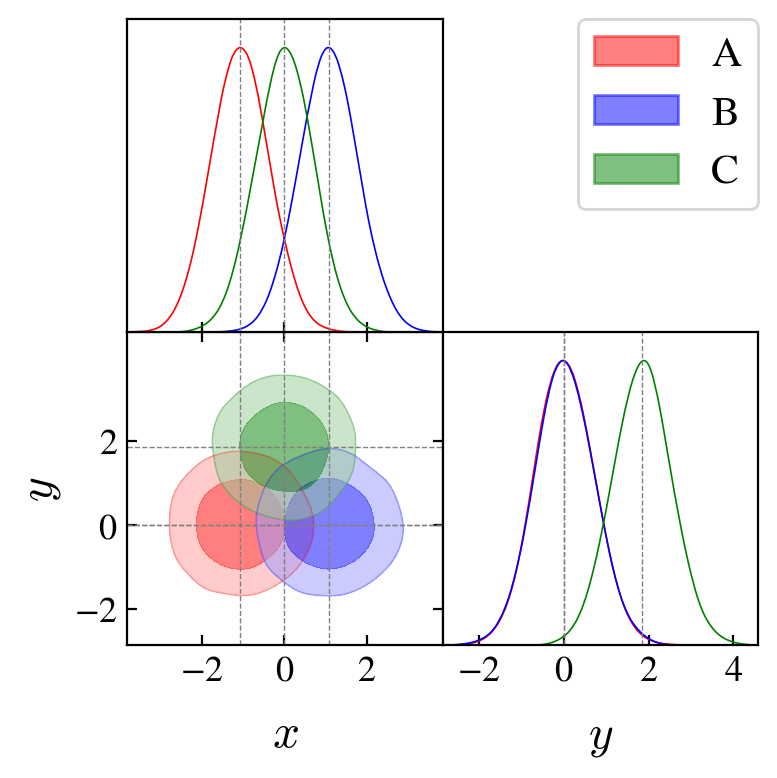

Factor: 3.515700301858557, PTE: 5.73e-05, N_sigma: 4.02


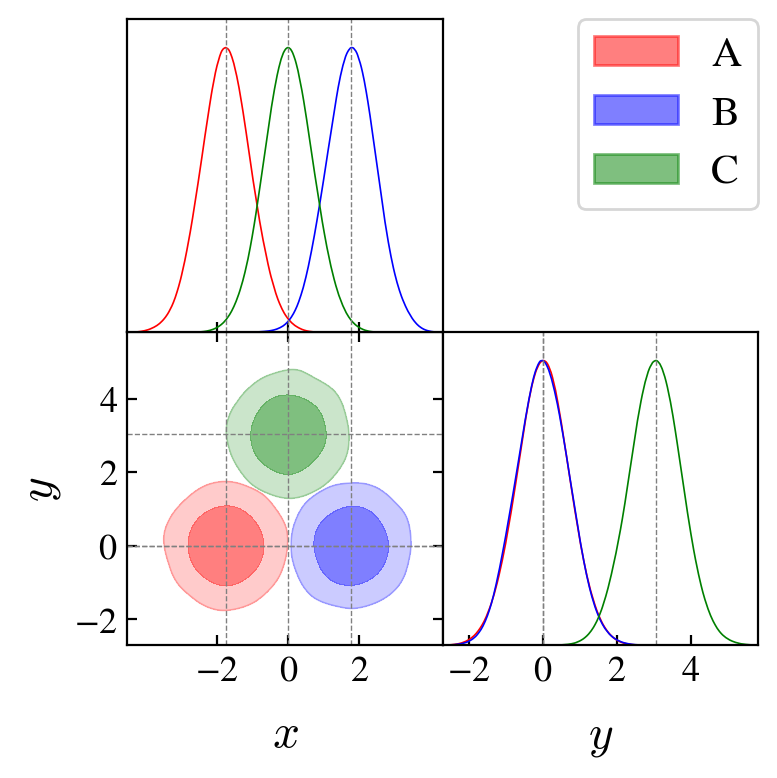

Factor: 4.863981513513553, PTE: 1.31e-09, N_sigma: 6.07


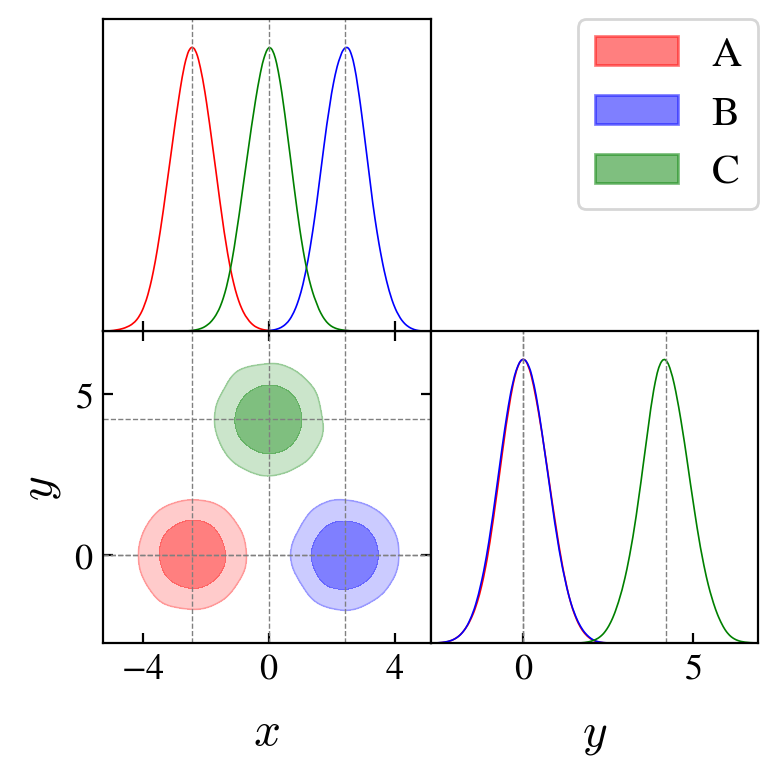

In [3]:
#Sharp triangle
#factor = [0., 2.1, 3.5]
factor = [L_iso_from_n(d=2, n=1), L_iso_from_n(d=2, n=2), L_iso_from_n(d=2, n=3)]


for i in range(len(factor)):
    mean_A = factor[i] * np.array([-1/2., 0.])
    mean_B = factor[i] * np.array([1/2, 0.])
    mean_C = factor[i] * np.array([0, np.sqrt(3)/2.])

    cov_A = np.eye(d) / 2
    cov_B = cov_A.copy()
    cov_C = cov_A.copy()

    r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
    r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
    r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))

    # Example usage:
    beta_L = (np.linalg.norm(r_1)**2 + np.linalg.norm(r_2)**2 + np.linalg.norm(r_3)**2)/L

    PTE = gamma(a=d, scale=1).sf(beta_L)
    n_sigma = np.sqrt(2)*erfcinv(PTE)

    print(f"Factor: {factor[i]}, PTE: {PTE:.3g}, N_sigma: {n_sigma:.3g}")


    names = ['x', 'y']
    labels = ['x', 'y']

    lim_x = np.array([-10, 10])
    lim_y = np.array([-10, 10])

    samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
    samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
    samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

    chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
    chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
    chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

    colors = ['red', 'blue', 'green']

    g = plots.get_subplot_plotter()
    g.settings.axes_fontsize   = 16   # tamaño de los números (ticks)
    g.settings.axes_labelsize  = 20   # tamaño de los nombres de parámetros (ejes)
    g.settings.legend_fontsize = 18   # tamaño de la leyenda

    g.triangle_plot([chain_A, chain_B, chain_C],\
                    filled=True, contour_args={'alpha':0.5},\
                    contour_colors=colors,
                    legend_labels=['A', 'B', 'C'])
    g.add_param_markers({'x':[mean_A[0], mean_B[0], mean_C[0]],
                        'y':[mean_A[1], mean_B[1], mean_C[1]],
                        },)

    os.chdir(os.path.join(path_global,'multimeter','notebooks','paper_plots','figures'))
    g.export('multidimensional_qdm_tension_vectors_triangle_L_{:.3g}.pdf'.format(factor[i]))
    g.export('multidimensional_qdm_tension_vectors_triangle_L_{:.3g}.svg'.format(factor[i]))
    g.export('multidimensional_qdm_tension_vectors_triangle_L_{:.3g}.png'.format(factor[i]))
    plt.show()

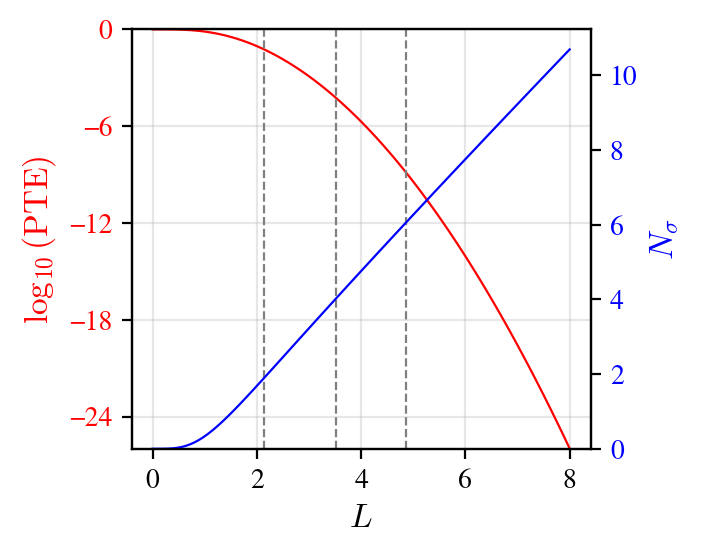

In [4]:
mpl.rcParams.update({
    "figure.figsize": (3.37, 2.6),     # UNA COLUMNA
    "font.size": 7,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 7,
    "lines.linewidth": 0.8,
    "font.family": "serif",
    "font.serif": ["TeX Gyre Termes", "Nimbus Roman", "Times New Roman", "DejaVu Serif"],
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})


#Sharp triangle
factor_line = [L_iso_from_n(d=2, n=1), L_iso_from_n(d=2, n=2), L_iso_from_n(d=2, n=3)]

factor = np.linspace(0, 8, 100)
PTE_arr = np.zeros(len(factor))
n_sigma_arr = np.zeros(len(factor))

for i in range(len(factor)):
    mean_A = factor[i] * np.array([-1/2., 0.]) 
    mean_B = factor[i] * np.array([1/2, 0.])
    mean_C = factor[i] * np.array([0, np.sqrt(3)/2.])

    cov_A = np.eye(d) / 2
    cov_B = cov_A.copy()
    cov_C = cov_A.copy()

    r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
    r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
    r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))

    # Example usage:
    beta_L = (np.linalg.norm(r_1)**2 + np.linalg.norm(r_2)**2 + np.linalg.norm(r_3)**2)/L

    PTE_arr[i] = gamma(a=d, scale=1).sf(beta_L)
    n_sigma_arr[i] = np.sqrt(2)*erfcinv(PTE_arr[i])


# --- Convertimos a log10 directamente ---
logPTE = np.log10(np.clip(PTE_arr, 1e-300, 1.0))  # evita -inf

fig, ax1 = plt.subplots()        # usa el tamaño de rcParams: (3.37, 2.6)
ax2 = ax1.twinx()

# Eje izquierdo: log10(PTE) con ticks enteros (-1, -2, -3, ...)
ax1.plot(factor, logPTE, color='red')
ax1.set_xlabel(r'$L$')                                  # NO forzar fontsize (usa rc)
ax1.set_ylabel(r'$\log_{10}(\mathrm{PTE})$', color='red')
ax1.tick_params(axis='y', labelcolor='red')

from matplotlib.ticker import MaxNLocator
pmin = int(np.floor(np.nanmin(logPTE)))
pmax = int(np.ceil(np.nanmax(logPTE)))
ax1.set_ylim(pmin, pmax)
ax1.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))  # máx ~5 ticks
ax1.xaxis.set_major_locator(MaxNLocator(nbins=5))

# Líneas guía en L de referencia
for x0 in factor_line:
    ax1.axvline(x=x0, color='gray', linestyle='--', linewidth=0.8)

# Eje derecho: N_sigma (escala automática y sin exagerar altura)
ax2.plot(factor, n_sigma_arr, color='blue')
ax2.set_ylabel(r'$N_\sigma$', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ymax = float(np.nanmax(n_sigma_arr))
ax2.set_ylim(0, max(1.0, 1.05*ymax))


# Grid suave solo en el eje izq (para no duplicar líneas)
ax1.grid(alpha=0.3)

plt.tight_layout(pad=0.02)
plt.savefig('multidimensional_qdm_tension_vectors_L_vs_PTE_Nsigma.svg', bbox_inches='tight')
plt.savefig('multidimensional_qdm_tension_vectors_L_vs_PTE_Nsigma.pdf', bbox_inches='tight')
plt.savefig('multidimensional_qdm_tension_vectors_L_vs_PTE_Nsigma.png', dpi=300, bbox_inches='tight')
plt.show()



In [5]:
factor_line

[2.142778070122352, 3.515700301858557, 4.863981513513553]